# 1. Data Exploration and Preparation




## 1.1 Setting Up Proper Libraries

First, let's ensure we have all the proper libraries we need in order to achieve our task.

In [ ]:
# Installers incase Google Colab doesn't have these libraries installed
!pip install torch
!pip install torchvision
!pip install torchinfo

For this project, we'll primarily be relying on: *torch* and *torchvision*.

Some other standard libraries we import are:
*numpy, seaborn, matplotlib, random, os, cv2, glob, sklearn,* and *PIL.*

In [ ]:
import torch
import torchvision
from torchvision import transforms, datasets
import torchvision.transforms.functional as T_F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import random as rn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models

Since we'll be using Google Colab, in order to use our data, we need to mount to our Google Drive directory that contains all the train/test images.


In [ ]:
from google.colab import drive
import os
import cv2
from glob import glob

from sklearn.model_selection import train_test_split
from PIL import Image

import random

drive.mount('/content/drive')

Mounted at /content/drive


In addition, we set both the seed for random and pytorch to 42 for reproducability.

In [ ]:
random.seed(42)
torch.manual_seed(42)

We define the current working directory, *(cwd)*, as follows:

In [ ]:
# Define current working directory (cwd)
cwd = os.getcwd() + '/drive/MyDrive/CSE 144 Final - Annabel + Richard'

Now Google Colab requires that you have adequete permissions in order for you to download data. You should verify that Colab has permission to read into this directory.

**If it doesn't work, you'll need to make a copy of the entire directory and re-run this program.**

## 1.2 Importing the Training Data

We initially used ImageFolder() to grab all the files within the train directory. However, due to the improper mapping of images to labels, we opted to import the training images manually.

Note, this method is significantly slower and can take anywhere from **30 seconds** to **12 minutes**.

In [ ]:
train_dir = cwd + '/train/train'

label_folders = os.listdir(train_dir)

train_dataset = []

for label in label_folders:
    curr_label_dir = os.path.join(train_dir, label)

    curr_label_images = os.listdir(curr_label_dir)
    train_images_paths = [os.path.join(curr_label_dir, file) for file in curr_label_images if file.lower().endswith(('jpg', 'jpeg', '.png'))]

    for path in train_images_paths:
        image = Image.open(path)

        if image.mode == 'L':
            image = image.convert('RGB')

        train_dataset.append((image, int(label)))


Once the images are imported, we display them to check if they are properly associated with their respective labels.

In [ ]:
# Ensure labels are properly connected with their images

# Change 'search' to any label value 0-99
search = 2

for image, label in train_dataset:
    if label == search:
        plt.imshow(image)
        plt.show()

## 1.3 Splitting into Train/Validation Sets

We utilize sklearn's *train_test_split()* function to split the indices of our training data into training/validation sets.

If running locally (i.e. on your local computer), this cell may take **1-2 minutes.**

In [ ]:
# Split into train and validation datasets
indices = list(range(len(train_dataset)))

train_indices, val_indices = train_test_split(indices, test_size=0.2)

train_samples = [train_dataset[i] for i in train_indices]
val_samples = [train_dataset[i] for i in val_indices]

print(len(train_samples))
print(len(val_samples))

# Verify that validation set is in format: (PIL image, label)
print(val_samples[0])

800
200
(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x748 at 0x7B6F78AE9390>, 12)


## 1.4 Data Augmentation

Once we've properly split our data in train and validation sets, we can now begin data augmentation to help with generalization.

Since we've opted to use the Vision Transformer, the required dimensions of all images will be: ***512x512***

In addition to resizing all images, we also ensure to convert them from PIL images to Tensors, and normalize them using the ImageNet mean and standard deviation values.

We only apply the data augmentations on the training set, of which we do the following:

*   RandomResizedCrop
*   RandomHorizonalFlip
*   RandomRotation
*   ColorJitter (brightness, contrast, saturation, hue)
*   ***GaussianBlur (we decided to omit this as it returned us consistently poorer results)***


Note that we want to ensure that validation and test sets (which we import later) are also properly resized, converted to tensors, and normalized.

In [ ]:
# Defining data transforms for train, validation, and test sets
size = 512

data_transforms = {
    'validation':transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'train':transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomResizedCrop(size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        # transforms.GaussianBlur(kernel_size=5, sigma=(1,5)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test':transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


In order to apply the transformations, we create our own CustomDataset class inheriting the constructors and methods from PyTorch's Dataset class.

In [ ]:
# Creating our Train and Validation Dataset Classes

class CustomDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image, label = self.samples[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Note that our data_transforms for train include some Data Augmentations
train_dataset = CustomDataset(train_samples, transform=data_transforms['train'])
val_dataset = CustomDataset(val_samples, transform=data_transforms['validation'])

And from here, we can finally put them into PyTorch DataLoader objects for training.

Note that we opted to use a ***batch_size = 32*** and decided to not shuffle the validation set for reproducability.

In [ ]:
# Finally we can create DataLoader instances for train and validation sets

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataloaders = {'train':train_loader, 'val':val_loader}
dataset_sizes = {'train':len(train_dataset), 'val':len(val_dataset)}

Now that the dataloaders are primed and ready, we can visualize some of the augmented images.

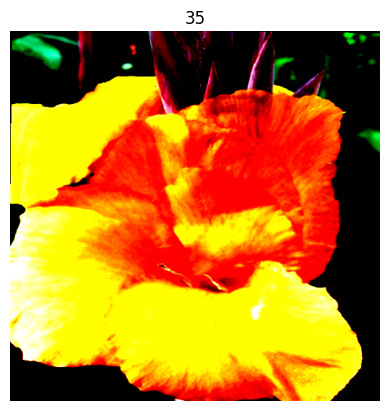

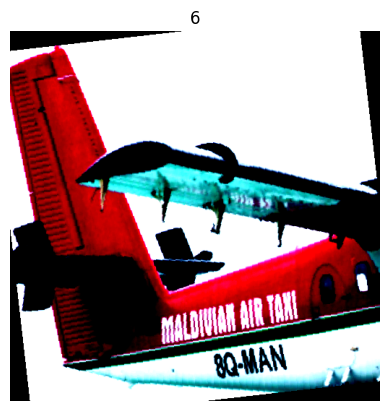

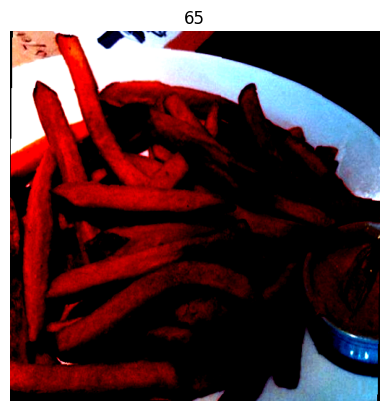

In [ ]:
# Display augmented images
def tensor_to_image(tensor):
    # Clipping the values to [0, 1] before converting to image
    tensor = torch.clamp(tensor, 0, 1)
    image = transforms.ToPILImage()(tensor)
    return image

# Iterate over batches in the DataLoader
for images, label in train_loader:
    # Visualize each image in the batch
    i = 0
    for tensor_image in images:
        # Convert tensor to PIL image
        image = tensor_to_image(tensor_image)

        # Display the image
        plt.imshow(image)
        plt.title(label[i].numpy())
        plt.axis('off')
        plt.show()

        i += 1
        if i == 3:
            break
    break


# 2. Base Model and Custom Classifier

After going through a handful of base models with varying weights including:
*   ConvNext-Base
*   EfficientNet-V2-L
*   ResNet-50
*   RegNet-128
*   RegNet-32

We settled on using a Vision Transformer, specifically model: ***ViT_L_16***



In [ ]:
# Importing our baseline model
# model = torchvision.models.convnext_base(weights='DEFAULT').cuda()
# model = torchvision.models.efficientnet_v2_l(weights='DEFAULT').cuda()
# model = torchvision.models.resnet50(weights='DEFAULT').cuda()
# model = torchvision.models.regnet_y_128gf(weights='DEFAULT').cuda()
# model = torchvision.models.regnet_y_32gf(weights='RegNet_Y_32GF_Weights.IMAGENET1K_SWAG_E2E_V1').cuda()

model = torchvision.models.vit_l_16(weights='ViT_L_16_Weights.IMAGENET1K_SWAG_E2E_V1').cuda()

Taking a look at the architecture of the Vision Transformer, we can see that it uses multi-layered perceptrons (MLPs) inside of encoder blocks.

In [ ]:
# Taking a quick look at the architecture of our model
from torchinfo import summary
summary(model=model, col_names=["num_params", "trainable"])


In [ ]:
# More specifically, we can print out the details of each layer
print(model)

# 3. Defining Our Training Loop

Now that we have a base model defined, we can start to define our training loop.

Here, we define our function *train_model()* which takes in the base model, a loss function, an optimizer function, and the total number of epochs to train.

This function saves the best parameter weights locally and returns the model with the best parameters weights based off of lowest validation loss.

In [ ]:
import copy

def train_model(model, criterion, optimizer, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            i = 0
            for inputs, labels in dataloaders[phase]:
                # print("Batch: ", i ,"/", len(dataloaders[phase]))
                i += 1
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Track history if in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs.cuda())
                    _, preds = torch.max(outputs.cpu(), 1)
                    loss = criterion(outputs.cpu(), labels)

                    # backward pass + optimize if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}', end=' ')

            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), cwd + '/best_params.pth')

        print()
    model.load_state_dict(best_model_wts)
    return model

# 4. Training Our Model

## 4.1 Freezing the Model and Defining our Custom Head

Alrighty! Our training loop has been defined, we can begin training our model.

First, we need to ensure all of the base models parameters are frozen.

In [ ]:
# We need to freeze the entire model except for the classifier/head/top layers in which we customize ourselves

for param in model.parameters():
    param.requires_grad = False

Then, we can add our custom classifier/head/top layer so that our model maps to 100 softmaxed outputs instead of ImageNet's 1000.

We also decided to add a BatchNormalization layer and a Dropout layer into the architecture of our head. Adding these two layers significantly boosted generalization and helped with stopping overfitting issues.

In [ ]:
# Defining our custom head
# model.avgpool.requires_grad = True

model.heads = nn.Sequential(
    # Maybe add a batch normalization layer here?
    nn.BatchNorm1d(num_features = 1024),
    nn.Dropout(p=0.5),
    nn.Linear(in_features = 1024, out_features=1024),
    nn.Linear(in_features = 1024, out_features=100)
).cuda()

We can now check to see if all layers except the classifier/head/top layer are frozen.

In [ ]:
# Verify that the layers are frozen
summary(model=model, col_names=["num_params", "trainable"])

## 4.2 Training Our Model

To train our model, we opted to use:

*   Loss Function: ***Cross Entropy Loss*** (since this it seemed to perform better with classification)
*   Optimizer: ***Stochastic Gradient Descent*** with a learning rate of 0.001 and momentum value of 0.9

While initially we did consider Adam for our optimizer, we settled on SGD as it allowed us to utilize momentum which helped significantly in boosting accuracy.

In [ ]:
# Define our criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Colab limited our training to only a few hours. In order to save our progress, we would load our best params that were saved in the training loop before continuing training.

Otherwise, we would just train the model from scratch. Note that we decided to run for ***100 epochs*** which in reality, we rarely required all epochs and opted to early stop if there was little to no progress being made.

Training was done on both the Colab GPUs and our local laptop GPUs (we utilized a RTX 3050 Laptop and a RTX 3060). Colab was ultimately the superior option, cutting training time significantly, but we used our own GPUs by letting our models train overnight.

In [ ]:
# Training

if os.path.exists(cwd + '/best_params.pth'):
    print("Loading Most Recent Checkpoint")
    model.load_state_dict(torch.load(cwd + "/best_params.pth"))

model = train_model(model, criterion, optimizer, num_epochs=100)

<All keys matched successfully>

If training reached its completion and we ran for all 100 epochs, we then save the parameters to our directory.

In [ ]:
# Save our transfer learned model
torch.save(model.state_dict(), cwd + '/vit_l_16_100epochs.pth')

# 5. Fine-Tuning Our Model

Once our custom classifier has been trained to a good loss and accuracy, we can then go back and unfreeze some layers to try and to fine-tune our model even more.

We opted to only unfreeze one encoder layer near the end as to not significantly increase computation time.

In [ ]:
# We're going to go back and unfreeze some of our models pre-trained weights

for param in model.encoder.layers.encoder_layer_23.parameters():
    param.requires_grad = True

In [ ]:
# Check that the architecture is still the same
print(model)

In [ ]:
# Verify that the layers have been unfrozen
summary(model=model, col_names=["num_params", "trainable"])

Once the encoder layer is unfrozen, we can run our model with the same loss function and optimizer, but we adjust the learning rate to be a factor lower so that it doesn't throw off the already well adjusted weights.

In [ ]:
# And now we re-train our model with a much lower learning rate and less epochs
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

model = train_model(model, criterion, optimizer, num_epochs=10)

In [ ]:
# Save our finetuned model
torch.save(model.state_dict(), cwd + '/vit_l_16_100epochs_ft.pth')

# 6. Testing Our Model

In [ ]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torchvision.models as models
import numpy as np
from google.colab import drive
import os
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
from PIL import Image

drive.mount('/content/drive')

We are now ready to test our model on the test dataset for submission to Kaggle!

**To Teaching Staff:** We've made it easy for you to test and evaluate our model. You don't have to run anything above Section 6! (if you don't want to)

To verify either the raw or finetuned model (they resulted in the same accuracies either way), you can change the variable *file_name* to either:

*   ***'/vit_l_16_100epochs.pth'*** - for the raw model
*   ***'/vit_l_16_100epochs_ft.pth'*** - for the finetuned model (default)

In addition, you should also ensure the current working directory (cwd) is accessible through Google Drive. See Section 1.1 for more details on this.




In [ ]:
file_name = '/vit_l_16_100epochs_ft.pth'

In [ ]:
cwd = os.getcwd() + '/drive/MyDrive/CSE 144 Final - Annabel + Richard'

In order to allow for all running of these cells without running anything above, we need to re-import all these libaries, re-define our model and custom head, as well as import the test data

In [ ]:
# Redundant reloading of model + custom head
model = torchvision.models.vit_l_16(weights='ViT_L_16_Weights.IMAGENET1K_SWAG_E2E_V1').cuda()

model.heads = nn.Sequential(
    nn.BatchNorm1d(num_features = 1024),
    nn.Dropout(p=0.5),
    nn.Linear(in_features = 1024, out_features=1024),
    nn.Linear(in_features = 1024, out_features=100)
).cuda()

size = 512

data_transforms = {
    'validation':transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'train':transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomResizedCrop(size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        # transforms.GaussianBlur(kernel_size=5, sigma=(1,5)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test':transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

Downloading: "https://download.pytorch.org/models/vit_l_16_swag-4f3808c9.pth" to /root/.cache/torch/hub/checkpoints/vit_l_16_swag-4f3808c9.pth
100%|██████████| 1.14G/1.14G [00:18<00:00, 65.5MB/s]


Once all the libraries are imported, we can load our parameters into the model

In [ ]:
if os.path.exists(cwd + file_name):
    print("Loading Most Recent Save")
    model.load_state_dict(torch.load(cwd + file_name))

Here we load the test images from our directory and perform our transformations on them before creating a dataset class for them and pushing them into a DataLoader object.

In [ ]:
# Import the test dataset
test_dir = cwd + "/test/test"

test_images_names = os.listdir(test_dir)
test_images_paths = [os.path.join(test_dir, file) for file in test_images_names if file.lower().endswith(('.jpg', '.jpeg', '.png'))]

test_dataset = [] # Should be a list of tensor images
test_ids = []


for path in test_images_paths:
    test_ids.append(path.split("/")[-1])
    image = Image.open(path)

    if image.mode == 'L':
        image = image.convert('RGB')
    tensor_image = data_transforms['test'](image)
    test_dataset.append(tensor_image)

In [ ]:
# Custom Test Dataset Class
class TestDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image = self.samples[idx]

        return image

test_dataset = TestDataset(test_dataset)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

From here we are finally ready to test our model! We will pass all our images through the model and see what its predictions are!

In [ ]:
predictions = []
ind = 1

for images in test_loader:
    model.eval()
    # print(len(images))
    with torch.no_grad():
        outputs = model(images.cuda())
    _, predicted = torch.max(outputs.cpu().data, 1)
    predictions.append(predicted.numpy())
    ind += 1
predictions = np.concatenate(predictions).tolist()


Finally, we can map the predicted labels to their IDs and organize them into a submission.csv file.

After this cell completes, you should be able to go back to the directory and the updated submission.csv file should be there.

In [ ]:
import csv
import re

# Sample data

# Create a list of tuples (file_name, label)
file_label_tuples = list(zip(test_ids, predictions))

# print(file_label_tuples)

# Sort the list of tuples based on file names as natural numbers
sorted_tuples = sorted(file_label_tuples, key=lambda x: [int(s) if s.isdigit() else s.lower() for s in re.split('([0-9]+)', x[0])])

# Specify the path within your Google Drive directory
csv_file_path = cwd + '/submission.csv'

with open(csv_file_path, 'w', newline='') as csv_file:
    fieldnames = ['ID', 'Label']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

    # Write the header
    writer.writeheader()

    # Write the data
    for file_name, label in sorted_tuples:
        writer.writerow({'ID': file_name, 'Label': label})
